# Show that this implementation can work with a low tolerance

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import cmocean

In [2]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [3]:
plt.style.use('./correlation.mplstyle')

In [4]:
horizontal_factor = 1
n_ranges = [5, 10, 15, 20]
alltols = [-1, -2, -3, -4, -7, -11, -15]
n_samples = 1000
corrs1 = []
for n_range in n_ranges:
    corrs2 = []
    for log10tol in alltols:
        fname = f"/scratch2/tsmith/generic-matern-covariance/sampling/llc90/zstores/matern-corr/log10tol{log10tol:03d}.{n_range:02d}dx.{horizontal_factor:02}xi.{n_samples}samples"
        corrs2.append(xr.open_zarr(fname))
    corrs1.append(xr.concat(corrs2, dim='log10tol'))
    
cds = xr.concat(corrs1, dim='n_range')

In [5]:
cds.nbytes / 1e9

15.629346952

In [6]:
cds.load();

## A simpler plot

In [7]:
kk = 25
ix = 90
iy = 165

In [8]:
def calc_error(xds, dim, dsel):
    
    corr = cds[f"corr_{dim}"].sel({dim:dsel})
    #corr = corr.sel(other)
    avg_dims = tuple(d for d in ["ix","iy","k"] if d != dim)
    
    corr = corr.mean(avg_dims)
    xds[f"abs_error_{dim}"] = np.abs(corr - cds['ideal_corr'])
    #corr = corr.quantile([.1, .5, .9], dim=avg_dims)
    #xds[f"abs_error_{dim}"] = np.abs(corr - cds['ideal_corr']).quantile([.1, .5, .9], dim=avg_dims)
    xds[f"rel_error_{dim}"] = xds[f"abs_error_{dim}"] / cds["ideal_corr"]
    return xds

In [37]:
def plot_error(xds, dim, dsel, ax):
    
    relerr = xds[f"rel_error_{dim}"]
    
    for n_range in xds["n_range"].values:
        plotme = relerr.where(relerr.shifty == -n_range, drop=True).sel(n_range=n_range)
        plotme = plotme.squeeze()
        p = plotme.plot(ax=ax, marker='o', label=r"$\hat{\rho} = %d$" % n_range)
        
        #median = plotme.sel(quantile=.5)
        #p = median.plot(ax=ax, marker='o', label=r"$\hat{\rho} = %d$" % n_range)
        
        #lo = plotme.sel(quantile=0.9)
        #hi = plotme.sel(quantile=.1)
        #ax.fill_between(plotme.log10tol, lo, hi, color=p[0].get_color(), alpha=.3)
    
    ax.set(xlabel=r"$\log_{10}($Tolerance$)$",
           ylabel="Relative Error",
           title='',
           xticks=xds.log10tol)

In [38]:
def plot_iterations(xds, ax):
    
    for n_range in xds.n_range.values:
        
        
        plotme = xds["avg_sor_iters"].sel(n_range=n_range)
        plotme.plot(x="log10tol", marker='o', ax=ax, label=r"$\hat{\rho} = %d$" % n_range)
        
    ax.set(xlabel=r"$\log_{10}($Tolerance$)$",
           ylabel='Iterations',
           title='',
           yscale='log',
           xticks=np.arange(-15,0,2))
    

In [39]:
k = 25
ix = 90
iy = 165

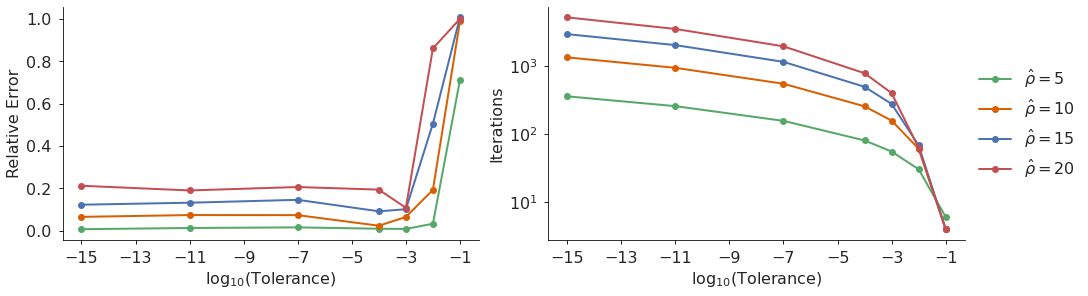

In [48]:
dim = "ix"
dsel = ix
cds = calc_error(cds, dim, dsel)

fig, axs = plt.subplots(1,2, figsize=(15,4),
                        constrained_layout=True,
                        sharex=True)

plot_error(cds, dim, dsel, axs[0])
plot_iterations(cds, axs[1])
axs[1].legend(loc='center left', bbox_to_anchor=(1., .5))
fig.savefig(f"{fig_dir}/matern_llc90_error_and_iters.pdf", bbox_inches='tight')

In [47]:

frac =cds.avg_sor_iters.sel(log10tol=-15)/cds.avg_sor_iters.sel(log10tol=-3)
for n_range in cds.n_range.values:
    
    print(float(frac.sel(n_range=n_range)))

6.45014270910975
8.456344609082471
10.548389448133598
12.882656621327804


## Other dimensions

[(-0.01, 1.1)]

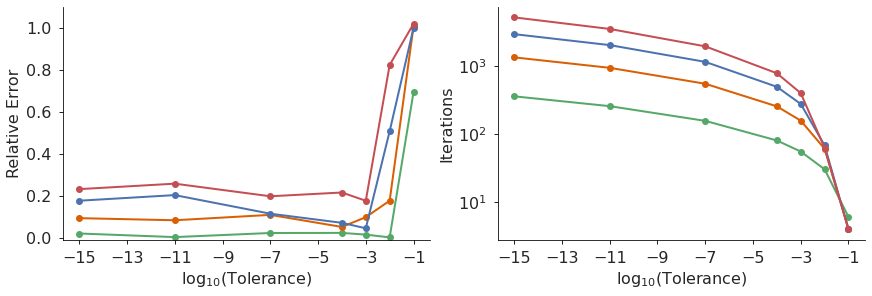

In [13]:
dim = "iy"
dsel = iy
cds = calc_error(cds, dim, dsel)

fig, axs = plt.subplots(1,2, figsize=(12,4),
                        constrained_layout=True,
                        sharex=True)

plot_error(cds, dim, dsel, axs[0])
plot_iterations(cds, axs[1])
axs[0].set(ylim=[None, 1.1])

[(-0.01, 1.1)]

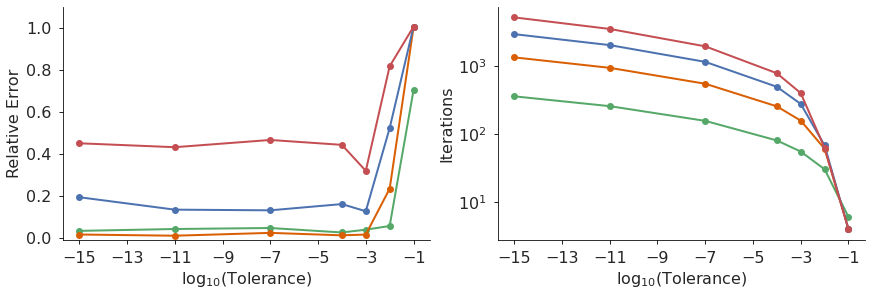

In [14]:
dim = "k"
dsel = k
cds = calc_error(cds, dim, dsel)

fig, axs = plt.subplots(1,2, figsize=(12,4),
                        constrained_layout=True,
                        sharex=True)

plot_error(cds, dim, dsel, axs[0])
plot_iterations(cds, axs[1])
axs[0].set(ylim=[None, 1.1])

[(-0.01, 1.1)]

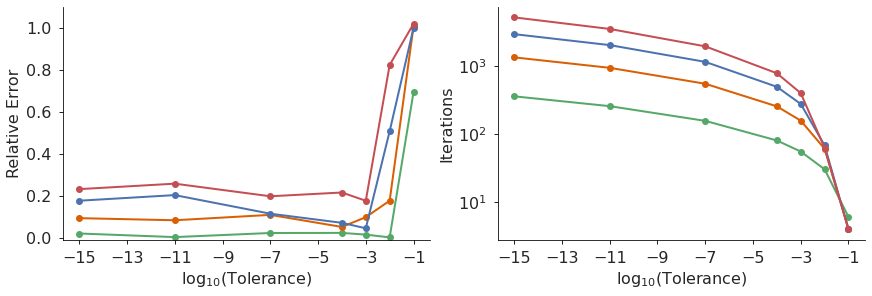

In [15]:
dim = "iy"
dsel = iy

fig, axs = plt.subplots(1,2, figsize=(12,4),
                        constrained_layout=True,
                        sharex=True)

plot_error(cds, dim, dsel, axs[0])
plot_iterations(cds, axs[1])
axs[0].set(ylim=[None, 1.1])

## Other plots

In [16]:
abs_err = np.abs(cds.corr_ix.sel(ix=ix).mean(['k','iy']) - cds['ideal_corr'])
abs_err.name = 'abserr'
rel_err = abs_err / cds.ideal_corr
rel_err.name = 'relerr'

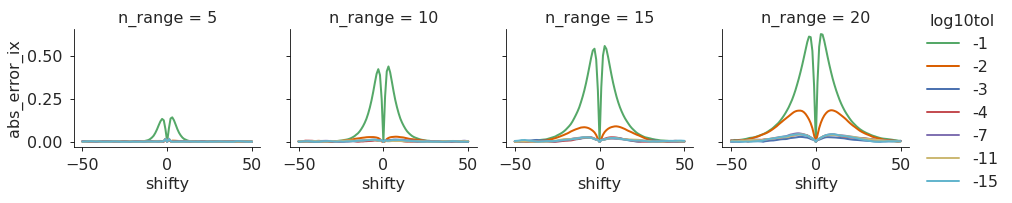

In [17]:
cds.abs_error_ix.plot.line(x='shifty', col='n_range')

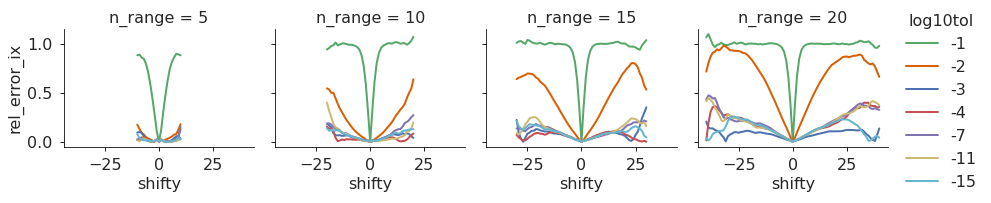

In [18]:
cds.rel_error_ix.where(cds.rho_hat <= cds.n_range*2).plot.line(x='shifty', col='n_range')

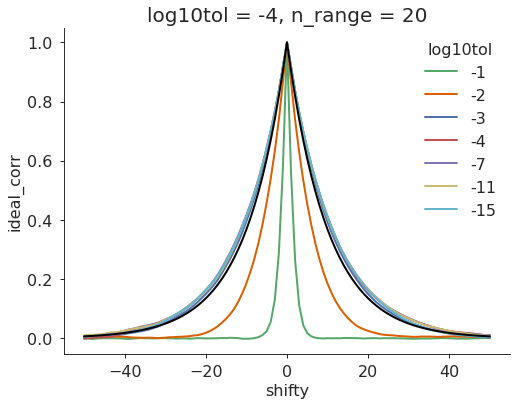

In [19]:
nr = 20
cds.corr_ix.sel(ix=ix).mean(['k','iy']).sel(n_range=nr).plot.line(x='shifty')
cds.ideal_corr.sel(n_range=nr,log10tol=-4).plot(color='k')